# Exploring Dandiset 001433: Breathing Rhythm and Place Dataset in Freely-Behaving Mice

**Notebook generated with the assistance of AI. Please review and interpret the code and results with care.**

## Overview

This notebook provides an introduction to [Dandiset 001433 (draft)](https://dandiarchive.org/dandiset/001433/draft), which contains multimodal recordings from freely-behaving mice, including:
- Olfactory bulb local field potentials (LFP)
- Sniffing (thermistor voltage)
- Behavioral sniff event features (inhalation and exhalation times)

These data are organized in Neurodata Without Borders (NWB) files, each corresponding to a session.

**Aim:** This notebook helps researchers get started on exploring and reanalyzing the dataset using code, remote file streaming, and visualizations.

**We will cover:**
1. Loading Dandiset asset information.
2. Exploring the main contents of an NWB file.
3. Loading and plotting segments of the SniffSignal and LFP.
4. Extracting and visualizing inhalation/exhalation event times.

**Note:** All NWB data are accessed via remote streaming (no local file download).

## Required Packages

The following Python packages are required (assume already installed):
- `dandi` (DANDI API client)
- `h5py` (for reading NWB content via HDF5)
- `remfile` (for reading remote files)
- `pynwb` (for NWB format streaming)
- `numpy`
- `matplotlib`

Additional libraries (such as pandas) are not used here, to be consistent with the chat examples.

## 1. Listing NWB Files in the Dandiset

We start by listing a few of the NWB files available in Dandiset 001433 using the DANDI API.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

# Connect to the DANDI Archive and access the Dandiset (draft version)
client = DandiAPIClient()
dandiset = client.get_dandiset("001433", "draft")

# List the first 10 NWB files in the Dandiset
assets = dandiset.get_assets_by_glob("*.nwb")
file_names = [asset.path for asset in islice(assets, 10)]

print("Example NWB filenames in this Dandiset:")
for name in file_names:
    print("-", name)

Example NWB filenames in this Dandiset:
- sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb
- sub-4122/sub-4122_ses-20250507T152930_ecephys.nwb
- sub-4122/sub-4122_ses-20250507T152933_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T152941_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T152953_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153010_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153020_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153032_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153048_ecephys.nwb
- sub-4127/sub-4127_ses-20250507T153100_ecephys.nwb


## 2. Loading the Main Contents of an NWB File

Let's focus on the file `sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb`. We will load its contents remotely and summarize its primary modules, including acquisition (LFP, sniff), processing (behavior), and key metadata fields.

In [2]:
import h5py
import pynwb
import remfile

asset_path = "sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb"
asset = next(dandiset.get_assets_by_glob(asset_path))
url = asset.download_url

# Open the NWB file via remote streaming
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print summary information about the NWB file
print("NWB File identifier:", nwb.identifier)
print("Session description:", nwb.session_description)
print("Session start time:", nwb.session_start_time)
print("\nTop-level modules/groups present:")
if hasattr(nwb, '__dict__'):
    for k, v in nwb.__dict__.items():
        if isinstance(v, dict):
            print(f"- {k}: {list(v.keys())}")
        elif k in ['acquisition', 'processing', 'devices', 'electrode_groups']:
            print(f"- {k}: {list(v.keys())}")
        elif not k.startswith("_"):
            print(f"- {k}")

NWB File identifier: 4122_4
Session description: LFP and sniff recording
Session start time: 2025-05-07 15:29:27.359523-07:00

Top-level modules/groups present:
- _AbstractContainer__field_values: ['session_description', 'identifier', 'session_start_time', 'timestamps_reference_time', 'file_create_date', 'experimenter', 'acquisition', 'keywords', 'processing', 'electrodes', 'electrode_groups', 'devices', 'subject', 'experiment_description', 'lab', 'institution']


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## 3. Exploring and Visualizing Data Streams

### A. Sniff Signal (Thermistor Voltage)
The SniffSignal reflects the breathing/sniffing behavior of the mouse. Let's plot a ~10 second segment from the start of the session.

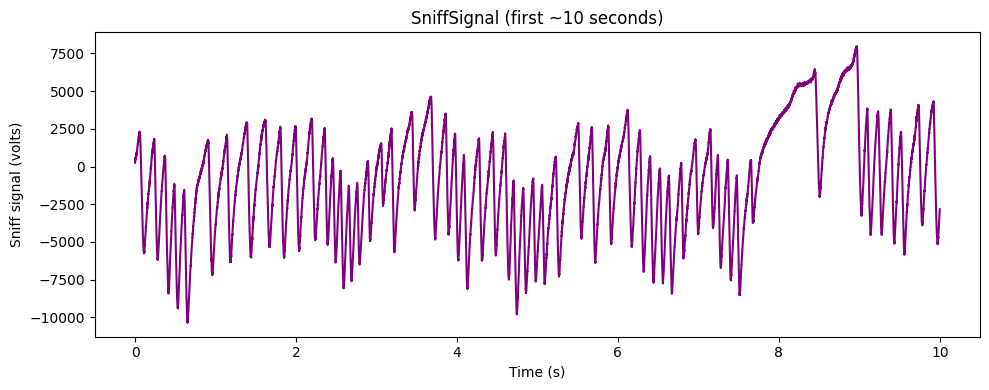

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Access SniffSignal and relevant sampling parameters
sniff = nwb.acquisition['SniffSignal']
rate = sniff.rate  # Hz
start_time = sniff.starting_time

# Select a 10 second segment
duration_sec = 10
num_samples = int(duration_sec * rate)
sniff_data = sniff.data[:num_samples]
sniff_times = start_time + (np.arange(num_samples) / rate)

# Plot the segment
plt.figure(figsize=(10, 4))
plt.plot(sniff_times, sniff_data, color='purple')
plt.xlabel('Time (s)')
plt.ylabel('Sniff signal (volts)')
plt.title('SniffSignal (first ~10 seconds)')
plt.tight_layout()
plt.show()

### B. Olfactory Bulb Local Field Potential (LFP)
The LFP acquisition contains multichannel signals from the olfactory bulb. We will visualize a 2-second segment from the first channel (channel 0).

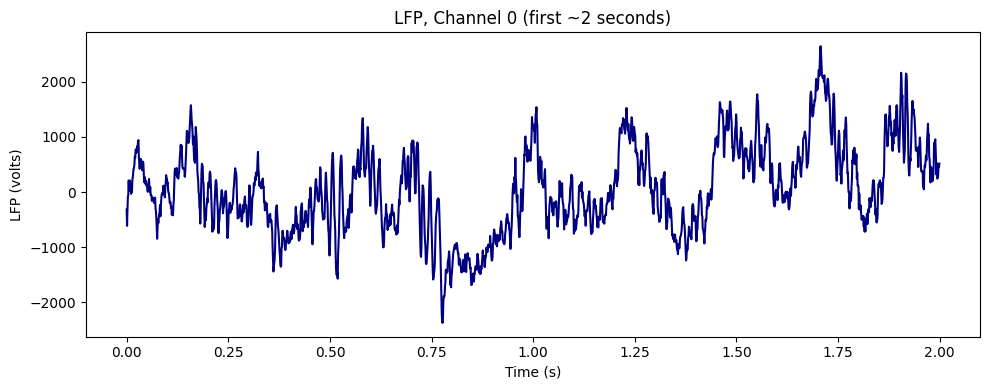

In [4]:
# Access LFP and parameters
lfp = nwb.acquisition['LFP']
lfp_rate = lfp.rate
lfp_start_time = lfp.starting_time

duration_sec = 2
num_samples = int(duration_sec * lfp_rate)
lfp_data = lfp.data[:num_samples, 0]  # channel 0
lfp_times = lfp_start_time + (np.arange(num_samples) / lfp_rate)

# Plot the segment
plt.figure(figsize=(10, 4))
plt.plot(lfp_times, lfp_data, color='navy')
plt.xlabel('Time (s)')
plt.ylabel('LFP (volts)')
plt.title('LFP, Channel 0 (first ~2 seconds)')
plt.tight_layout()
plt.show()

## 4. Examining the "behavior" Processing Module

The behavior processing module contains time series for inhalation and exhalation events extracted from the sniffing signal. Let's list the available data interfaces and describe their contents.

In [5]:
# Access the 'behavior' processing module
behavior = nwb.processing['behavior']

# Print the description and the available event series
print("Description of 'behavior' processing module:", behavior.description)
print("\nAvailable data interfaces / time series:")
for iface in behavior.data_interfaces:
    print("-", iface)

Description of 'behavior' processing module: Sniff event features

Available data interfaces / time series:
- exhalation_time
- inhalation_time


## 5. Raster Plot: Inhalation and Exhalation Event Times

The event times are stored in milliseconds and need to be converted to seconds. We will display a raster plot of inhalation and exhalation events over the first 60 seconds of the session.

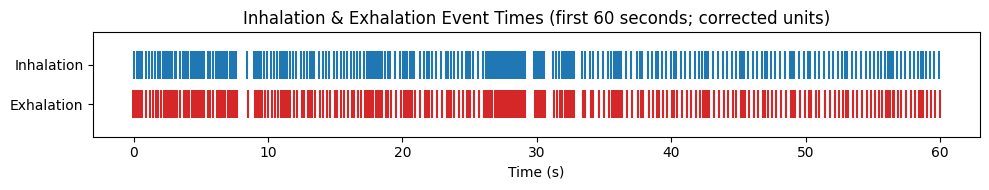

In [6]:
# Extract and convert event timestamps
inhalation_times = behavior.data_interfaces['inhalation_time'].timestamps[:]
exhalation_times = behavior.data_interfaces['exhalation_time'].timestamps[:]

# Correct: convert from ms to seconds
inhalation_times_s = inhalation_times / 1000.0
exhalation_times_s = exhalation_times / 1000.0

# Restrict to first 60 seconds
inhalation_60 = inhalation_times_s[inhalation_times_s <= 60]
exhalation_60 = exhalation_times_s[exhalation_times_s <= 60]

# Plot raster of inhalation/exhalation events
plt.figure(figsize=(10, 2))
plt.eventplot([inhalation_60, exhalation_60], colors=['tab:blue', 'tab:red'],
              lineoffsets=[1, 0], linelengths=0.7)
plt.xlabel('Time (s)')
plt.yticks([1, 0], ['Inhalation', 'Exhalation'])
plt.title('Inhalation & Exhalation Event Times (first 60 seconds; corrected units)')
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated how to:
- List and access NWB files from Dandiset 001433 using the DANDI API
- Load remote NWB data using `pynwb` and related tools
- Visualize both raw and event-based behavioral/electrophysiological streams

You can now adapt this workflow to explore other files or deepen analyses of neural-behavioral coupling in this dataset. For more info or advanced analysis, consult the [DANDI Archive documentation](https://www.dandiarchive.org/) and [Neurodata Without Borders documentation](https://www.nwb.org/).